# Inspect Best Student vs Teacher on Full Audio

This notebook loads the trained TinyVAD student checkpoint and the Silero teacher,
then visualizes their probability alignment on any audio clip. Update the
`audio_path` assignment at the bottom to target your file.


C:\Users\xeangao\AppData\Local\Temp\ipykernel_197908\4181011258.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_checkpoint, map_locatio

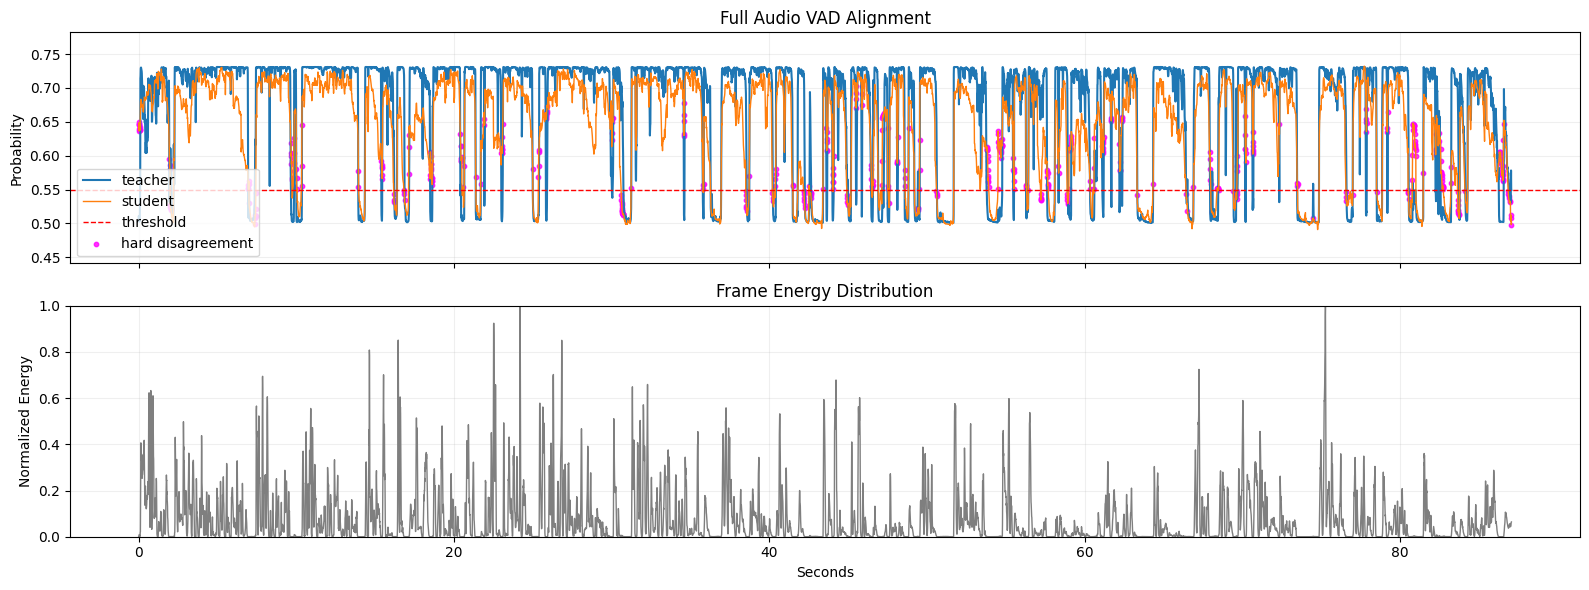

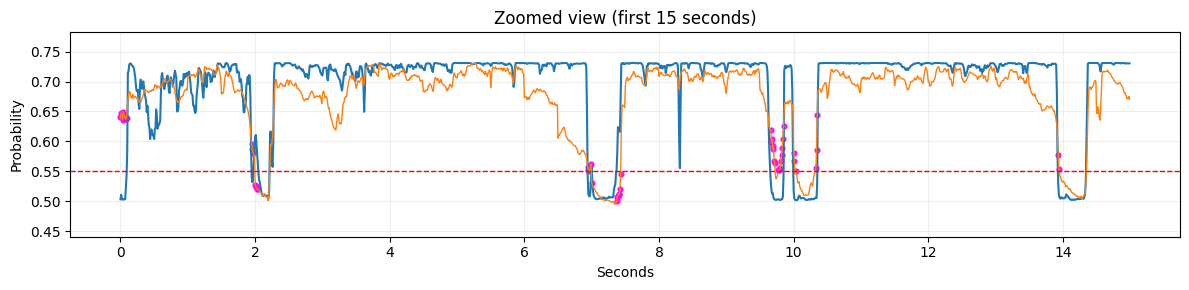

Hard Agreement %: 93.92
Soft Margin Agreement %: 99.05
Consistent Seconds per Minute: 56.35


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from vad_distill.config import load_config
from vad_distill.config.data_paths import resolve_paths
from vad_distill.preprocessing.audio_utils import compute_log_mel, load_audio
from vad_distill.teacher.frame_level_teacher import FrameLevelTeacher
from vad_distill.tiny_vad.model import build_tiny_vad_model

config = load_config()
paths = resolve_paths(config.get("paths", {}))


def run_teacher_on_full_audio(audio_tensor: torch.Tensor, teacher_cfg: dict) -> np.ndarray:
    window_size = int(teacher_cfg.get("window_size", 512))
    hop_size = int(teacher_cfg.get("hop_size", 160))
    device = teacher_cfg.get("device", "auto")
    teacher = FrameLevelTeacher(device=device, window_size=window_size, hop_size=hop_size)
    probs, _ = teacher.infer(audio_tensor.cpu().numpy(), sr=16_000)
    return probs.astype(np.float32)


def extract_normalized_mel(waveform: np.ndarray, chunk_cfg: dict) -> torch.Tensor:
    mel = compute_log_mel(
        waveform,
        sample_rate=16_000,
        n_mels=int(chunk_cfg["n_mels"]),
        frame_len=float(chunk_cfg["frame_len"]),
        frame_hop=float(chunk_cfg["frame_hop"]),
    )
    mel = (mel - mel.mean()) / (mel.std() + 1e-6)
    return torch.from_numpy(mel).to(torch.float32)


def compute_frame_energy(
    waveform: np.ndarray,
    sample_rate: int,
    frame_len: float,
    frame_hop: float,
) -> np.ndarray:
    frame_size = int(round(frame_len * sample_rate))
    hop_size = int(round(frame_hop * sample_rate))
    if frame_size <= 0 or hop_size <= 0:
        raise ValueError("Invalid frame configuration for energy computation.")
    energies: list[float] = []
    start = 0
    total = len(waveform)
    while start < total:
        end = start + frame_size
        frame = waveform[start:end]
        if frame.shape[0] < frame_size:
            pad = np.zeros(frame_size, dtype=np.float32)
            pad[: frame.shape[0]] = frame
            frame = pad
        energy = float(np.mean(frame**2))
        energies.append(energy)
        if end >= total:
            break
        start += hop_size
    energy_arr = np.asarray(energies, dtype=np.float32)
    if energy_arr.size == 0:
        return np.zeros(0, dtype=np.float32)
    energy_arr = (energy_arr - energy_arr.min()) / (energy_arr.max() - energy_arr.min() + 1e-8)
    return energy_arr


def run_student_chunks(
    mel_tensor: torch.Tensor,
    student_model: torch.nn.Module,
    chunk_size: int,
    stride: int,
    device: torch.device,
) -> np.ndarray:
    mel_tensor = mel_tensor.to(device)
    num_frames = mel_tensor.shape[0]
    if num_frames == 0:
        return np.zeros(0, dtype=np.float32)
    if num_frames < chunk_size:
        pad = chunk_size - num_frames
        pad_frame = mel_tensor[-1:].repeat(pad, 1)
        mel_tensor = torch.cat([mel_tensor, pad_frame], dim=0)
        num_frames = chunk_size

    accum = torch.zeros(num_frames, dtype=torch.float32, device=device)
    counts = torch.zeros(num_frames, dtype=torch.float32, device=device)

    starts = range(0, num_frames, stride)
    student_model.eval()
    with torch.no_grad():
        for start in starts:
            end = min(start + chunk_size, num_frames)
            chunk = mel_tensor[start:end]
            valid_len = end - start
            if valid_len < chunk_size:
                pad = mel_tensor[-1:].repeat(chunk_size - valid_len, 1)
                chunk = torch.cat([chunk, pad], dim=0)
            chunk = chunk.unsqueeze(0)
            prob = torch.sigmoid(student_model(chunk)).squeeze(0)
            accum[start:end] += prob[:valid_len]
            counts[start:end] += 1.0

    torch.clamp_(counts, min=1.0)
    student_full = (accum / counts).cpu().numpy().astype(np.float32)
    return student_full


def plot_audio_vad_alignment(audio_path, student_checkpoint, config) -> None:
    audio_path = Path(audio_path)
    chunk_cfg = config.get("chunking", {})
    teacher_cfg = config.get("teacher", {})
    waveform = load_audio(audio_path, target_sr=16_000)
    audio_tensor = torch.from_numpy(waveform).to(torch.float32)
    teacher_full = run_teacher_on_full_audio(audio_tensor, teacher_cfg)
    mel_tensor = extract_normalized_mel(waveform, chunk_cfg)
    energy_full = compute_frame_energy(
        waveform,
        sample_rate=16_000,
        frame_len=float(chunk_cfg["frame_len"]),
        frame_hop=float(chunk_cfg["frame_hop"]),
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    student = build_tiny_vad_model(config).to(device)
    checkpoint = torch.load(student_checkpoint, map_location=device)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    student.load_state_dict(state_dict)
    student.eval()

    chunk_size = int(chunk_cfg["chunk_size"])
    stride = int(chunk_cfg["stride"])
    student_full = run_student_chunks(mel_tensor, student, chunk_size, stride, device)
    student_full = student_full[: len(mel_tensor)]

    min_len = min(len(teacher_full), len(student_full), len(energy_full))
    if min_len == 0:
        raise ValueError("Empty alignment: check audio length or chunking settings.")
    teacher_full = teacher_full[:min_len]
    student_full = student_full[:min_len]
    energy_full = energy_full[:min_len]
    frame_hop = float(chunk_cfg["frame_hop"])
    time_axis = np.arange(min_len) * frame_hop

    # --- hard labels and agreement metrics ---
    threshold = 0.55
    margin = 0.15

    teacher_hard = teacher_full >= threshold
    student_hard = student_full >= threshold

    hard_agreement = float(np.mean(teacher_hard == student_hard)) * 100.0
    soft_margin_agreement = float(np.mean(np.abs(student_full - teacher_full) <= margin)) * 100.0

    consistent_mask = teacher_hard == student_hard
    consistent_seconds = float(consistent_mask.sum()) * frame_hop
    total_seconds = float(min_len) * frame_hop
    consistent_seconds_per_minute = (
        60.0 * consistent_seconds / total_seconds if total_seconds > 0.0 else 0.0
    )

    fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
    axes[0].plot(time_axis, teacher_full, label="teacher", linewidth=1.5)
    axes[0].plot(time_axis, student_full, label="student", linewidth=1.0)

    # threshold line
    axes[0].axhline(
        threshold,
        color="red",
        linestyle="--",
        linewidth=1.0,
        label="threshold",
    )

    # highlight disagreement frames only (where hard labels differ)
    disagree_mask = teacher_hard != student_hard
    if np.any(disagree_mask):
        axes[0].scatter(
            time_axis[disagree_mask],
            student_full[disagree_mask],
            s=10,
            color="magenta",
            alpha=0.8,
            label="hard disagreement",
        )

    ymin = min(teacher_full.min(), student_full.min()) - 0.05
    ymax = max(teacher_full.max(), student_full.max()) + 0.05
    axes[0].set_ylim(ymin, ymax)
    axes[0].set_ylabel("Probability")
    axes[0].set_title("Full Audio VAD Alignment")
    axes[0].legend()
    axes[0].grid(True, alpha=0.2)

    axes[1].plot(time_axis, energy_full, color="tab:gray", linewidth=1.0)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel("Seconds")
    axes[1].set_ylabel("Normalized Energy")
    axes[1].set_title("Frame Energy Distribution")
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # optional zoomed view on first 15 seconds to inspect disagreements
    zoom_seconds = 15.0
    zoom_frames = int(zoom_seconds / frame_hop)
    zoom_frames = min(zoom_frames, min_len)
    if zoom_frames > 0:
        t_zoom = time_axis[:zoom_frames]
        teacher_zoom = teacher_full[:zoom_frames]
        student_zoom = student_full[:zoom_frames]
        disagree_zoom = disagree_mask[:zoom_frames]

        fig_zoom, ax_zoom = plt.subplots(1, 1, figsize=(12, 3))
        ax_zoom.plot(t_zoom, teacher_zoom, label="teacher", linewidth=1.5)
        ax_zoom.plot(t_zoom, student_zoom, label="student", linewidth=1.0)
        ax_zoom.axhline(
            threshold,
            color="red",
            linestyle="--",
            linewidth=1.0,
            label="threshold",
        )
        if np.any(disagree_zoom):
            ax_zoom.scatter(
                t_zoom[disagree_zoom],
                student_zoom[disagree_zoom],
                s=12,
                color="magenta",
                alpha=0.9,
                label="hard disagreement",
            )
        ax_zoom.set_xlabel("Seconds")
        ax_zoom.set_ylabel("Probability")
        ax_zoom.set_title("Zoomed view (first 15 seconds)")
        ax_zoom.set_ylim(ymin, ymax)
        ax_zoom.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    print(f"Hard Agreement %: {hard_agreement:.2f}")
    print(f"Soft Margin Agreement %: {soft_margin_agreement:.2f}")
    print(f"Consistent Seconds per Minute: {consistent_seconds_per_minute:.2f}")


student_checkpoint = paths["checkpoint_dir"] / "best.pt"
audio_path = Path("demo.opus")

assert student_checkpoint.exists(), f"Missing checkpoint: {student_checkpoint}"
assert audio_path.exists(), f"Missing audio file: {audio_path}"

plot_audio_vad_alignment(
    audio_path,
    student_checkpoint=student_checkpoint,
    config=config,
)



# Benchmark: student vs teacher

This section computes a few simple metrics on the same audio clip used above:

- runtime for teacher and student VAD
- student real-time factor (audio seconds / student inference seconds)
- frame-level MSE / MAE between student and teacher probabilities
- optional peak GPU memory (if CUDA is available)

Update `audio_path` and `student_checkpoint` as needed, then run the cell below.


In [6]:
import time


def benchmark_vad(audio_path: Path, student_checkpoint: Path, config: dict) -> dict:
    audio_path = Path(audio_path)
    chunk_cfg = config.get("chunking", {})
    teacher_cfg = config.get("teacher", {})

    # Load waveform
    waveform = load_audio(audio_path, target_sr=16_000)
    duration_sec = len(waveform) / 16_000.0
    audio_tensor = torch.from_numpy(waveform).to(torch.float32)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Teacher timing + peak memory
    teacher_peak_mb = None
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    t0 = time.perf_counter()
    teacher_full = run_teacher_on_full_audio(audio_tensor, teacher_cfg)
    t_teacher = time.perf_counter() - t0

    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated(device)
        teacher_peak_mb = peak_bytes / (1024**2)

    # Student setup
    mel_tensor = extract_normalized_mel(waveform, chunk_cfg)
    student = build_tiny_vad_model(config).to(device)
    checkpoint = torch.load(student_checkpoint, map_location=device)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    student.load_state_dict(state_dict)
    student.eval()

    chunk_size = int(chunk_cfg["chunk_size"])
    stride = int(chunk_cfg["stride"])

    # Student timing + peak memory
    student_peak_mb = None
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device)

    t1 = time.perf_counter()
    student_full = run_student_chunks(mel_tensor, student, chunk_size, stride, device)
    t_student = time.perf_counter() - t1

    if torch.cuda.is_available():
        peak_bytes = torch.cuda.max_memory_allocated(device)
        student_peak_mb = peak_bytes / (1024**2)

    # Align lengths
    min_len = min(len(teacher_full), len(student_full))
    if min_len == 0:
        raise ValueError("Empty alignment: check audio length or chunking settings.")
    teacher_full = teacher_full[:min_len]
    student_full = student_full[:min_len]

    # Errors
    diff = student_full - teacher_full
    mse = float(np.mean(diff**2))
    mae = float(np.mean(np.abs(diff)))

    metrics = {
        "audio_duration_sec": round(duration_sec, 2),
        "num_frames": int(min_len),
        "teacher_time_sec": round(t_teacher, 3),
        "student_time_sec": round(t_student, 3),
        "student_real_time_factor": round(duration_sec / max(t_student, 1e-6), 2),
        "mse_vs_teacher": round(mse, 6),
        "mae_vs_teacher": round(mae, 6),
    }

    if teacher_peak_mb is not None:
        metrics["teacher_peak_cuda_mem_mb"] = round(teacher_peak_mb, 1)
    if student_peak_mb is not None:
        metrics["student_peak_cuda_mem_mb"] = round(student_peak_mb, 1)

    return metrics


bench_results = benchmark_vad(audio_path, student_checkpoint, config)
bench_results


C:\Users\xeangao\AppData\Local\Temp\ipykernel_178932\1975604874.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_checkpoint, map_location

{'audio_duration_sec': 87.09,
 'num_frames': 8706,
 'teacher_time_sec': 4.475,
 'student_time_sec': 0.094,
 'student_real_time_factor': 922.08,
 'mse_vs_teacher': 0.002693,
 'mae_vs_teacher': 0.038835,
 'teacher_peak_cuda_mem_mb': 20.0,
 'student_peak_cuda_mem_mb': 33.9}

# Benchmark charts

The cell below visualizes the benchmark results stored in `bench_results`:

- bar chart of teacher vs student runtime for the same clip
- real-time factors for teacher and student
- peak CUDA memory for both models (if a GPU is used)

Re-run the benchmark cell if you change `audio_path` or `student_checkpoint`.


In [10]:
def benchmark_vad_cpu(audio_path: Path, student_checkpoint: Path, config: dict) -> dict:
    """CPU-only benchmark mirroring benchmark_vad (no CUDA required)."""
    try:
        import psutil  # type: ignore[import-not-found]
    except Exception:  # pragma: no cover - optional dependency
        psutil = None  # type: ignore[assignment]

    audio_path = Path(audio_path)
    chunk_cfg = config.get("chunking", {})
    teacher_cfg = config.get("teacher", {}).copy()
    teacher_cfg["device"] = "cpu"

    # Load waveform
    waveform = load_audio(audio_path, target_sr=16_000)
    duration_sec = len(waveform) / 16_000.0
    audio_tensor = torch.from_numpy(waveform).to(torch.float32)

    # Teacher on CPU
    t0 = time.perf_counter()
    teacher_full = run_teacher_on_full_audio(audio_tensor, teacher_cfg)
    t_teacher = time.perf_counter() - t0
    teacher_mem_cpu = None
    if "psutil" in locals() and psutil is not None:
        teacher_mem_cpu = psutil.Process().memory_info().rss / (1024**2)

    # Student on CPU
    mel_tensor = extract_normalized_mel(waveform, chunk_cfg)
    device = torch.device("cpu")
    student = build_tiny_vad_model(config).to(device)
    checkpoint = torch.load(student_checkpoint, map_location=device)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    student.load_state_dict(state_dict)
    student.eval()

    chunk_size = int(chunk_cfg["chunk_size"])
    stride = int(chunk_cfg["stride"])

    t1 = time.perf_counter()
    student_full = run_student_chunks(mel_tensor, student, chunk_size, stride, device)
    t_student = time.perf_counter() - t1
    student_mem_cpu = None
    if "psutil" in locals() and psutil is not None:
        student_mem_cpu = psutil.Process().memory_info().rss / (1024**2)

    # Align lengths
    min_len = min(len(teacher_full), len(student_full))
    if min_len == 0:
        raise ValueError("Empty alignment: check audio length or chunking settings.")
    teacher_full = teacher_full[:min_len]
    student_full = student_full[:min_len]

    # Errors
    diff = student_full - teacher_full
    mse = float(np.mean(diff**2))
    mae = float(np.mean(np.abs(diff)))

    metrics = {
        "audio_duration_sec": round(duration_sec, 2),
        "num_frames": int(min_len),
        "teacher_time_sec_cpu": round(t_teacher, 3),
        "student_time_sec_cpu": round(t_student, 3),
        "teacher_rtf_cpu": round(duration_sec / max(t_teacher, 1e-6), 2),
        "student_rtf_cpu": round(duration_sec / max(t_student, 1e-6), 2),
        "mse_vs_teacher": round(mse, 6),
        "mae_vs_teacher": round(mae, 6),
    }
    if teacher_mem_cpu is not None:
        metrics["teacher_memory_mb_cpu"] = round(teacher_mem_cpu, 1)
    if student_mem_cpu is not None:
        metrics["student_memory_mb_cpu"] = round(student_mem_cpu, 1)

    return metrics


roles = ["teacher", "student"]

teacher_time = bench_results.get("teacher_time_sec", 0.0)
student_time = bench_results.get("student_time_sec", 0.0)

# Teacher real-time factor is computed from duration and teacher time
audio_duration = bench_results.get("audio_duration_sec", 0.0)
rtf_teacher = audio_duration / max(teacher_time, 1e-6)
rtf_student = bench_results.get("student_real_time_factor", 0.0)

teacher_mem = bench_results.get("teacher_peak_cuda_mem_mb")
student_mem = bench_results.get("student_peak_cuda_mem_mb")

# Also run CPU-only benchmark so that users without GPUs can compare
bench_results_cpu = benchmark_vad_cpu(audio_path, student_checkpoint, config)

print("Benchmark summary (same clip):")
for key, value in bench_results.items():
    print(f"  {key}: {value}")

print("\nCPU-only benchmark (same clip):")
for key, value in bench_results_cpu.items():
    print(f"  {key}: {value}")

# Single compact table for GPU/auto vs CPU (monospaced ASCII)
print("\nTeacher vs student (GPU/auto vs CPU, same clip):")

rows = []
rows.append(
    [
        "teacher",
        "gpu/auto" if torch.cuda.is_available() else "cpu",
        teacher_time,
        rtf_teacher,
        teacher_mem if teacher_mem is not None else float("nan"),
    ]
)
rows.append(
    [
        "student",
        "gpu/auto" if torch.cuda.is_available() else "cpu",
        student_time,
        rtf_student,
        student_mem if student_mem is not None else float("nan"),
    ]
)
rows.append(
    [
        "teacher",
        "cpu",
        bench_results_cpu["teacher_time_sec_cpu"],
        bench_results_cpu["teacher_rtf_cpu"],
        bench_results_cpu.get("teacher_memory_mb_cpu", float("nan")),
    ]
)
rows.append(
    [
        "student",
        "cpu",
        bench_results_cpu["student_time_sec_cpu"],
        bench_results_cpu["student_rtf_cpu"],
        bench_results_cpu.get("student_memory_mb_cpu", float("nan")),
    ]
)

header = ["role", "device", "time_sec", "rtf", "memory_mb"]
col_widths = [max(len(h), 10) for h in header]

def fmt_cell(val: float | str) -> str:
    if isinstance(val, str):
        return val
    if np.isnan(val):
        return "N/A"
    return f"{val:.2f}"

# adjust widths based on data
for row in rows:
    for i, val in enumerate(row):
        text = fmt_cell(val)
        col_widths[i] = max(col_widths[i], len(text))

# print header
header_line = "  ".join(h.ljust(col_widths[i]) for i, h in enumerate(header))
sep_line = "  ".join("-" * col_widths[i] for i in range(len(header)))
print(header_line)
print(sep_line)

# print rows
for row in rows:
    line = "  ".join(fmt_cell(val).ljust(col_widths[i]) for i, val in enumerate(row))
    print(line)



C:\Users\xeangao\AppData\Local\Temp\ipykernel_178932\1189365324.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(student_checkpoint, map_location

Benchmark summary (same clip):
  audio_duration_sec: 87.09
  num_frames: 8706
  teacher_time_sec: 4.475
  student_time_sec: 0.094
  student_real_time_factor: 922.08
  mse_vs_teacher: 0.002693
  mae_vs_teacher: 0.038835
  teacher_peak_cuda_mem_mb: 20.0
  student_peak_cuda_mem_mb: 33.9

CPU-only benchmark (same clip):
  audio_duration_sec: 87.09
  num_frames: 8706
  teacher_time_sec_cpu: 2.381
  student_time_sec_cpu: 0.279
  teacher_rtf_cpu: 36.57
  student_rtf_cpu: 312.0
  mse_vs_teacher: 0.002693
  mae_vs_teacher: 0.038828
  teacher_memory_mb_cpu: 1063.4
  student_memory_mb_cpu: 1010.0

Teacher vs student (GPU/auto vs CPU, same clip):
role        device      time_sec    rtf         memory_mb 
----------  ----------  ----------  ----------  ----------
teacher     gpu/auto    4.47        19.46       20.00     
student     gpu/auto    0.09        922.08      33.90     
teacher     cpu         2.38        36.57       1063.40   
student     cpu         0.28        312.00      1010.00   
